In [1]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import polars as pl
import pandas as pd
import yfinance as yf
import sklearn
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [2]:
# Версии необходимых библиотек
packages = [
    "Torch", "NumPy", "Polars", "Pandas", "Matplotlib", "Yfinance", "Scikit-learn", "NetworkX"
]

package_objects = [
    torch, np, pl, pd, mpl, yf, sklearn, nx
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""
    
    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.9.1+cu128"""
2,"""NumPy""","""2.3.5"""
3,"""Polars""","""1.35.2"""
4,"""Pandas""","""2.3.3"""
5,"""Matplotlib""","""3.10.7"""
6,"""Yfinance""","""0.2.66"""
7,"""Scikit-learn""","""1.7.2"""
8,"""NetworkX""","""3.6"""


### Посмотрим на исходные данные

In [ ]:
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.isna().sum()

Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

In [ ]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


На текущий момент модели обучаются только на 'Close', хотя в данных куда больше фич, которые могли быть полезны. Это одна из причин, почему модели плохо предсказывают.

Сразу заметим, что в текущем коде нормализация данных происходит до разбиения на train/test и scaler обучается на всех данных, а не только на train. Это вызывает утечку информации.

Посмотрим, как выглядит график 'Close':

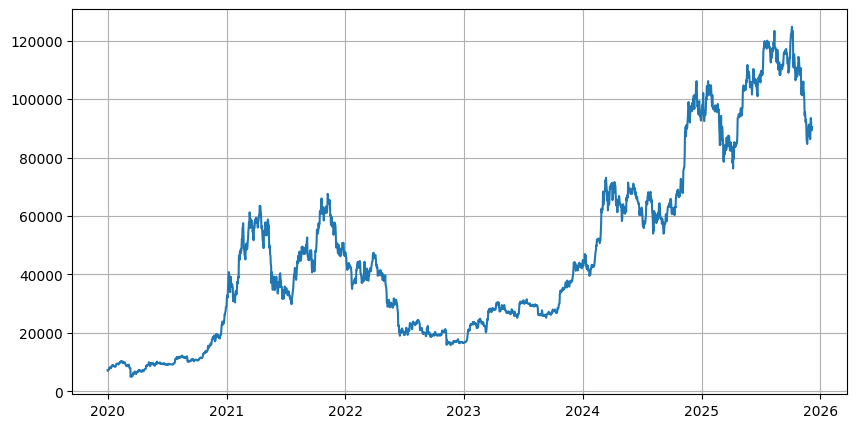

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data['Close'])
plt.grid(True)
plt.show()

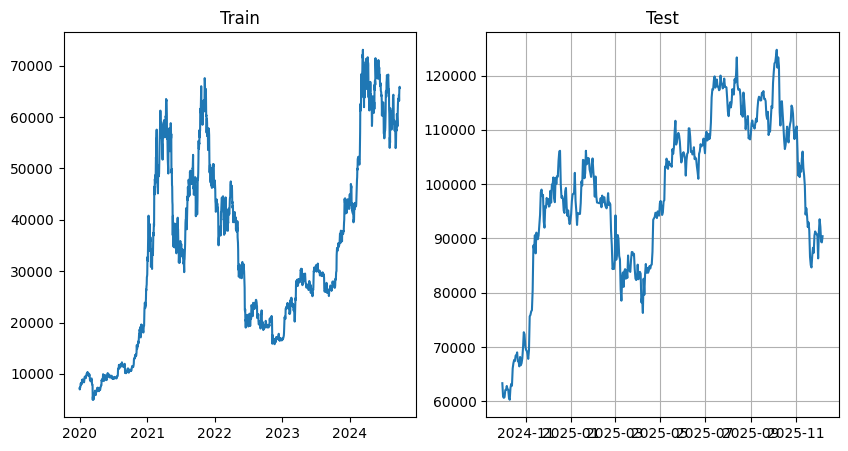

In [ ]:
train_size = int(0.8 * len(data['Close']))
y_train, y_test = data['Close'][:train_size], data['Close'][train_size:]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
axes[0].plot(y_train)
axes[1].plot(y_test)
axes[0].set_title("Train")
axes[1].set_title("Test")
plt.grid(True)
plt.show()

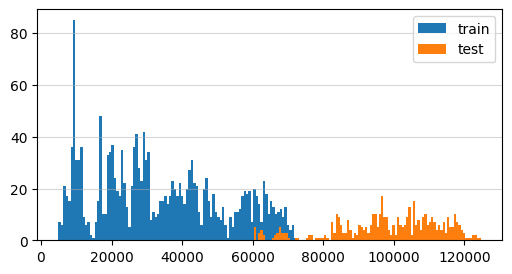

In [ ]:
plt.figure(figsize=(6, 3))
plt.hist(y_train, bins=100, label='train')
plt.hist(y_test, bins=100, label='test')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

Видим, что данные на трейне и тесте распределены по-разному. Значения на тесте сильно больше значений на трейне.

### Scaler-ы


Так, разберемся, что происходит в MinMaxScaler. Как я понял, MinMaxScaler умеет работать со значениями меньше min и больше max в исходных данных и будет выдавать < 0 и > 1 для таких данных.

Проблема может возникнуть, если на вход модели попадут данные < 0 или > 1, так как при обучении модель не видела таких данных. В текущем коде нормализуются сразу все данные, поэтому такой проблемы (скорее всего) не будет. Но если делать сперва разбиение train/test, а потом нормализацию, то эта проблема как раз вылезет, так как на тестовой выборке значения сильно больше, чем на train.


Возьмем самую первую реализацию RNN (которая работает пока-что лучше всего) и попробуем для нее несколько scaler-ов и сделаем правильное разбиение на train/test. (Я попросил нейроночки распихать код по отдельным функциям чтобы не заграмождать ноутбук, надеюсь штрафов за такое не будет)

Также будем считать лоссы на тестовой выборке при обучении, чтобы следить, переобучается модель или нет (да, так делать нельзя, но мы же все таки пытаемся понять, почему модель не работает)

In [ ]:
from HW3.base_rnn import run_rnn_pipeline

In [ ]:
run_rnn_pipeline(epochs=120, external_scaler = MinMaxScaler(), plot_name='MinMaxScaler_res.png') #По дефолту MinMaxScaler

[*********************100%***********************]  1 of 1 completed
  1%|          | 1/120 [00:01<02:34,  1.30s/it]

Epoch   0 | Train: 0.109684 | Test: 1.060123


  9%|▉         | 11/120 [00:13<02:15,  1.24s/it]

Epoch  10 | Train: 0.065246 | Test: 0.823166


 18%|█▊        | 21/120 [00:26<02:01,  1.23s/it]

Epoch  20 | Train: 0.040319 | Test: 0.437997


 26%|██▌       | 31/120 [00:42<01:57,  1.32s/it]

Epoch  30 | Train: 0.000909 | Test: 0.018550


 34%|███▍      | 41/120 [00:55<01:40,  1.28s/it]

Epoch  40 | Train: 0.000408 | Test: 0.010251


 42%|████▎     | 51/120 [01:10<01:46,  1.54s/it]

Epoch  50 | Train: 0.000407 | Test: 0.010099


 51%|█████     | 61/120 [01:23<01:16,  1.29s/it]

Epoch  60 | Train: 0.000407 | Test: 0.009998


 59%|█████▉    | 71/120 [01:36<01:00,  1.24s/it]

Epoch  70 | Train: 0.000406 | Test: 0.009899


 68%|██████▊   | 81/120 [01:52<00:50,  1.29s/it]

Epoch  80 | Train: 0.000405 | Test: 0.009802


 76%|███████▌  | 91/120 [02:04<00:35,  1.24s/it]

Epoch  90 | Train: 0.000405 | Test: 0.009707


 84%|████████▍ | 101/120 [02:19<00:31,  1.68s/it]

Epoch 100 | Train: 0.000404 | Test: 0.009614


 92%|█████████▎| 111/120 [02:32<00:11,  1.26s/it]

Epoch 110 | Train: 0.000403 | Test: 0.009523


100%|██████████| 120/120 [02:43<00:00,  1.36s/it]

Epoch 119 | Train: 0.000403 | Test: 0.009443


{'plot': 'plots/MinMaxScaler_res.png'}

In [ ]:
run_rnn_pipeline(epochs=120, external_scaler = StandardScaler(), plot_name='StandartScaler_res.png') #По дефолту MinMaxScaler

[*********************100%***********************]  1 of 1 completed
  1%|          | 1/120 [00:01<02:34,  1.30s/it]

Epoch   0 | Train: 0.894564 | Test: 11.755746


  9%|▉         | 11/120 [00:17<04:01,  2.22s/it]

Epoch  10 | Train: 0.006361 | Test: 1.186675


 18%|█▊        | 21/120 [00:29<02:07,  1.28s/it]

Epoch  20 | Train: 0.005918 | Test: 1.008859


 26%|██▌       | 31/120 [00:41<01:43,  1.17s/it]

Epoch  30 | Train: 0.005665 | Test: 0.887982


 34%|███▍      | 41/120 [00:56<01:52,  1.43s/it]

Epoch  40 | Train: 0.005501 | Test: 0.799328


 42%|████▎     | 51/120 [01:09<01:26,  1.26s/it]

Epoch  50 | Train: 0.005386 | Test: 0.731004


 51%|█████     | 61/120 [01:22<01:14,  1.26s/it]

Epoch  60 | Train: 0.005301 | Test: 0.676479


 59%|█████▉    | 71/120 [01:38<01:03,  1.29s/it]

Epoch  70 | Train: 0.005235 | Test: 0.631825


 68%|██████▊   | 81/120 [01:50<00:49,  1.26s/it]

Epoch  80 | Train: 0.005183 | Test: 0.594519


 76%|███████▌  | 91/120 [02:05<00:43,  1.49s/it]

Epoch  90 | Train: 0.005142 | Test: 0.562854


 84%|████████▍ | 101/120 [02:17<00:23,  1.23s/it]

Epoch 100 | Train: 0.005108 | Test: 0.535626


 92%|█████████▎| 111/120 [02:29<00:10,  1.22s/it]

Epoch 110 | Train: 0.005080 | Test: 0.511961


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]

Epoch 119 | Train: 0.005058 | Test: 0.493166


{'plot': 'plots/StandartScaler_res.png'}

In [ ]:
run_rnn_pipeline(epochs=120, external_scaler = RobustScaler(), plot_name='RobustScaler_res.png') #По дефолту MinMaxScaler

[*********************100%***********************]  1 of 1 completed
  1%|          | 1/120 [00:01<02:42,  1.37s/it]

Epoch   0 | Train: 0.390903 | Test: 5.503788


  9%|▉         | 11/120 [00:14<02:20,  1.29s/it]

Epoch  10 | Train: 0.002601 | Test: 0.310727


 18%|█▊        | 21/120 [00:26<02:02,  1.24s/it]

Epoch  20 | Train: 0.002539 | Test: 0.287062


 26%|██▌       | 31/120 [00:42<02:03,  1.39s/it]

Epoch  30 | Train: 0.002490 | Test: 0.267419


 34%|███▍      | 41/120 [00:55<01:40,  1.27s/it]

Epoch  40 | Train: 0.002450 | Test: 0.250795


 42%|████▎     | 51/120 [01:10<02:30,  2.17s/it]

Epoch  50 | Train: 0.002417 | Test: 0.236505


 51%|█████     | 61/120 [01:22<01:14,  1.26s/it]

Epoch  60 | Train: 0.002388 | Test: 0.224064


 59%|█████▉    | 71/120 [01:35<01:00,  1.24s/it]

Epoch  70 | Train: 0.002363 | Test: 0.213119


 68%|██████▊   | 81/120 [01:50<00:56,  1.45s/it]

Epoch  80 | Train: 0.002342 | Test: 0.203404


 76%|███████▌  | 91/120 [02:03<00:36,  1.25s/it]

Epoch  90 | Train: 0.002323 | Test: 0.194714


 84%|████████▍ | 101/120 [02:15<00:23,  1.25s/it]

Epoch 100 | Train: 0.002306 | Test: 0.186890


 92%|█████████▎| 111/120 [02:31<00:11,  1.29s/it]

Epoch 110 | Train: 0.002291 | Test: 0.179805


100%|██████████| 120/120 [02:42<00:00,  1.36s/it]

Epoch 119 | Train: 0.002279 | Test: 0.173975


{'plot': 'plots/RobustScaler_res.png'}

По графикам видно, что MinMaxScaler отработал лучше всех (?)

Переобучения и недообучения у таких моделей вроде как нет, лосс на трейне почти не меняется (нет недообучения), лосс на тесте не увеличивается (нет переобучения)

### Forecast

В коде forecast берет последние seq_len данных и по ним пытается предсказать следующие значения на days дней.

Во-первых, сейчас в коде не очень понятно, как тестировать такие предсказания, так как настоящих значений у нас нет.
Для решения этой проблемы можно просто брать в виде входных данных самые последние - 30 данные, и сравнивать вывод с оставшимися 30 реальными.

Во-вторых, модель при предсказании будущей цены опирается на свои же предсказания, то есть все ошибки в прошлых предсказаниях будут учитываться и в будущих. В том числе модель может предсказать значения больше 1 и меньше 0, из-за чего следующие предсказания будут еще более неточные, так как модель не видела таких данных при обучении.

На графиках (с практики и тех, что выше), можно заметить, что модель преуменьшает предсказания. Это мы и видим на графиках 30-дневных предсказаний. С каждым днем предсказанная цена все меньше, потому что модель каждый раз опирается на свои же уже заниженные предсказания и еще больше их занижает.

Итого понимаем, что чтобы 30-дневный прогноз хоть сколько то хорошо работал, нужно максимально уменьшить ошибку модели на единовременном предсказании (или пытаться строить прогноз сразу на 30 дней вперед)


### Проверим модели

Очень странно, что самая простая модель дает ошибки куда меньше, чем более сложные модели, причем на графиках ошибок таких моделей видно, что предсказание они очень сильно занижают. Это говорит о том, что либо модель не дообучилась и предсказывает +- среднее значение на трейне, либо наоборот переобучилась и привыкла предсказывать только маленькие значения.

Попробуем сперва уменьшить число эпох, а потом увеличить.

Возьмем модель GRU с практики и посмотрим на графики loss на train/test.

In [2]:
from GRU1 import run_gru_pipeline

In [ ]:
run_gru_pipeline(epochs=1, plot_name="gru_1_epoch.png")

[*********************100%***********************]  1 of 1 completed
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

Epoch  0 | Train Loss: 0.036087 | Test Loss: 0.013866


{'plot': 'plots/gru_1_epoch.png'}

In [ ]:
run_gru_pipeline(epochs=2, plot_name="gru_2_epoch.png")

[*********************100%***********************]  1 of 1 completed
 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Epoch  0 | Train Loss: 0.031385 | Test Loss: 0.013523


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]

Epoch  1 | Train Loss: 0.003558 | Test Loss: 0.013782


{'plot': 'plots/gru_2_epoch.png'}

In [ ]:
run_gru_pipeline(epochs=3, plot_name="gru_3_epoch.png")

[*********************100%***********************]  1 of 1 completed
 33%|███▎      | 1/3 [00:02<00:04,  2.37s/it]

Epoch  0 | Train Loss: 0.025386 | Test Loss: 0.025960


100%|██████████| 3/3 [00:06<00:00,  2.24s/it]

Epoch  2 | Train Loss: 0.002954 | Test Loss: 0.011207


{'plot': 'plots/gru_3_epoch.png'}

In [ ]:
run_gru_pipeline(epochs=4, plot_name="gru_4_epoch.png")

[*********************100%***********************]  1 of 1 completed
 25%|██▌       | 1/4 [00:02<00:07,  2.40s/it]

Epoch  0 | Train Loss: 0.029305 | Test Loss: 0.016684


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]

Epoch  3 | Train Loss: 0.003076 | Test Loss: 0.014883


{'plot': 'plots/gru_4_epoch.png'}

При малом числе эпох получаем результаты, схожие с самыми первыми RNN.

Попробуем взять побольше эпох

patience=10

In [3]:
run_gru_pipeline(epochs=100, plot_name="gru_100_epoch_1.png", patience=10)

[*********************100%***********************]  1 of 1 completed
  1%|          | 1/100 [00:00<00:45,  2.18it/s]

Epoch  0 | Train Loss: 0.043362 | Test Loss: 0.024989


 11%|█         | 11/100 [00:03<00:25,  3.56it/s]

Epoch 10 | Train Loss: 0.002308 | Test Loss: 0.002057


 21%|██        | 21/100 [00:06<00:29,  2.69it/s]

Epoch 20 | Train Loss: 0.001938 | Test Loss: 0.010440


 31%|███       | 31/100 [00:09<00:19,  3.45it/s]

Epoch 30 | Train Loss: 0.001522 | Test Loss: 0.006691


 33%|███▎      | 33/100 [00:10<00:20,  3.21it/s]


Early Stopping на эпохе 33


{'plot': 'plots/gru_100_epoch_1.png'}

patience=15

In [4]:
run_gru_pipeline(epochs=100, plot_name="gru_100_epoch_2.png", patience=15)

[*********************100%***********************]  1 of 1 completed
  1%|          | 1/100 [00:00<00:28,  3.48it/s]

Epoch  0 | Train Loss: 0.018798 | Test Loss: 0.009263


 11%|█         | 11/100 [00:03<00:24,  3.58it/s]

Epoch 10 | Train Loss: 0.001672 | Test Loss: 0.003988


 21%|██        | 21/100 [00:06<00:25,  3.06it/s]

Epoch 20 | Train Loss: 0.001437 | Test Loss: 0.001321


 31%|███       | 31/100 [00:09<00:20,  3.44it/s]

Epoch 30 | Train Loss: 0.001071 | Test Loss: 0.006157


 41%|████      | 41/100 [00:12<00:16,  3.57it/s]

Epoch 40 | Train Loss: 0.000872 | Test Loss: 0.004373


 41%|████      | 41/100 [00:12<00:17,  3.31it/s]


Early Stopping на эпохе 41


{'plot': 'plots/gru_100_epoch_2.png'}

patience=20

In [8]:
run_gru_pipeline(epochs=100, plot_name="gru_100_epoch_3.png", patience=20)

[*********************100%***********************]  1 of 1 completed
  1%|          | 1/100 [00:00<00:29,  3.32it/s]

Epoch  0 | Train Loss: 0.031516 | Test Loss: 0.004061


 11%|█         | 11/100 [00:03<00:25,  3.50it/s]

Epoch 10 | Train Loss: 0.002179 | Test Loss: 0.008410


 21%|██        | 21/100 [00:06<00:22,  3.55it/s]

Epoch 20 | Train Loss: 0.001650 | Test Loss: 0.006706


 31%|███       | 31/100 [00:09<00:24,  2.84it/s]

Epoch 30 | Train Loss: 0.001546 | Test Loss: 0.005070


 41%|████      | 41/100 [00:12<00:17,  3.47it/s]

Epoch 40 | Train Loss: 0.001585 | Test Loss: 0.006541


 46%|████▌     | 46/100 [00:13<00:16,  3.29it/s]


Early Stopping на эпохе 46


{'plot': 'plots/gru_100_epoch_3.png'}

In [11]:
run_gru_pipeline(epochs=100, plot_name="gru_100_epoch_4.png", patience=25)

[*********************100%***********************]  1 of 1 completed
  1%|          | 1/100 [00:00<00:30,  3.24it/s]

Epoch  0 | Train Loss: 0.023560 | Test Loss: 0.012709


 11%|█         | 11/100 [00:03<00:26,  3.42it/s]

Epoch 10 | Train Loss: 0.001483 | Test Loss: 0.001928


 21%|██        | 21/100 [00:06<00:28,  2.81it/s]

Epoch 20 | Train Loss: 0.001291 | Test Loss: 0.008145


 31%|███       | 31/100 [00:09<00:19,  3.50it/s]

Epoch 30 | Train Loss: 0.000985 | Test Loss: 0.002668


 41%|████      | 41/100 [00:12<00:16,  3.53it/s]

Epoch 40 | Train Loss: 0.000913 | Test Loss: 0.003998


 44%|████▍     | 44/100 [00:13<00:17,  3.29it/s]


Early Stopping на эпохе 44


{'plot': 'plots/gru_100_epoch_4.png'}

Как мы видим, предсказания стали куда лучше исходных. Скорее всего происходит что то такое:
 
На малом числе эпох модель понимает, что выгодно выдавать примерно среднее по входным данным.
На большем числе эпох модель начинает понимать паттерны в данных и ориентируется больше на них (ну или тоже предсказывает средний мусор)

### Итого

1) Проблема в использовании не всех доступных данных
2) Проблема в разных распределениях тренировочных и тестовых данных
3) Проблема в Forecast
4) Проблема в недообучении сложных моделей
5) Проблема в неправильном порядке разбиения/нормализации данных